## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

Пункт 1.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

0it [00:00, ?it/s]

26427392it [00:01, 16364657.14it/s]                             


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 112181.88it/s]           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:00, 4853025.96it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


8192it [00:00, 39042.72it/s]            

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [ ]:
batch_size_train = 64
batch_size_test = 1000

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=False)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


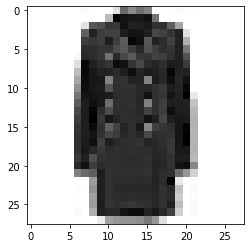

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r');

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
    self.fc1 = nn.Linear(64 * 7 * 7, 1000)
    self.fc2 = nn.Linear(1000, 200)
    self.out = nn.Linear(200, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
import torch.optim as optim
learning_rate = 0.00146

In [ ]:
net = CNN()
net = net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [ ]:
train_losses = []
test_losses = []
train_cntr = []
test_cntr = [batch_size_test]

In [ ]:
def train(epoch):
  net.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.to('cuda')
    labels = labels.to('cuda')
    optimizer.zero_grad()

    out = net(images)
    loss = F.nll_loss(out, labels)

    loss.backward()
    optimizer.step()

    total = labels.size(0)
    predicted = torch.max(out.data, 1)[1]
    correct = (predicted == labels).sum().item()

    if i % 10 == 0:
      print('Train Epoch: {}, Images: [{}/{}], Loss: {:.4f} Accuracy: {:.2f}%'.format(
          epoch, i*len(images), len(train_loader.dataset),
           loss.item(), ((correct/total) * 100)))
      train_losses.append(loss.item())
      train_cntr.append(i * batch_size_train + (epoch - 1)*len(train_loader.dataset)) 
      train_acc.append(((correct/total) * 100))
      torch.save(net.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
      

In [ ]:
def test():
  net.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to('cuda')
      labels = labels.to('cuda')
      out = net(images)
      test_loss += F.nll_loss(out, labels, size_average=False).item()
      pred = out.data.max(1, keepdim=True)[1]
      correct += pred.eq(labels.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc.append(100. * correct / len(test_loader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)
  
  

In [ ]:
n_epoches = 40
net = CNN()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  accuracy = test()
  if (accuracy >= 92):
    print ('Accuracy ' + str(accuracy) + '% was reached!')
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 1, Images: [0/60000], Loss: 2.3028 Accuracy: 7.81%
Train Epoch: 1, Images: [640/60000], Loss: 1.2152 Accuracy: 51.56%
Train Epoch: 1, Images: [1280/60000], Loss: 0.9586 Accuracy: 64.06%
Train Epoch: 1, Images: [1920/60000], Loss: 0.6766 Accuracy: 78.12%
Train Epoch: 1, Images: [2560/60000], Loss: 0.6332 Accuracy: 75.00%
Train Epoch: 1, Images: [3200/60000], Loss: 0.7681 Accuracy: 65.62%
Train Epoch: 1, Images: [3840/60000], Loss: 0.8750 Accuracy: 75.00%
Train Epoch: 1, Images: [4480/60000], Loss: 0.4493 Accuracy: 84.38%
Train Epoch: 1, Images: [5120/60000], Loss: 0.5065 Accuracy: 76.56%
Train Epoch: 1, Images: [5760/60000], Loss: 0.5717 Accuracy: 79.69%
Train Epoch: 1, Images: [6400/60000], Loss: 0.4975 Accuracy: 82.81%
Train Epoch: 1, Images: [7040/60000], Loss: 0.4821 Accuracy: 82.81%
Train Epoch: 1, Images: [7680/60000], Loss: 0.4632 Accuracy: 81.25%
Train Epoch: 1, Images: [8320/60000], Loss: 0.3799 Accuracy: 85.94%
Train Epoch: 1, Images: [8960/60000], Loss: 0.5255 Ac

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2995, Accuracy: 8922/10000 (89.22%)

Train Epoch: 2, Images: [0/60000], Loss: 0.2976 Accuracy: 92.19%
Train Epoch: 2, Images: [640/60000], Loss: 0.4349 Accuracy: 87.50%
Train Epoch: 2, Images: [1280/60000], Loss: 0.2585 Accuracy: 85.94%
Train Epoch: 2, Images: [1920/60000], Loss: 0.2988 Accuracy: 92.19%
Train Epoch: 2, Images: [2560/60000], Loss: 0.2299 Accuracy: 92.19%
Train Epoch: 2, Images: [3200/60000], Loss: 0.1377 Accuracy: 95.31%
Train Epoch: 2, Images: [3840/60000], Loss: 0.1754 Accuracy: 92.19%
Train Epoch: 2, Images: [4480/60000], Loss: 0.2004 Accuracy: 93.75%
Train Epoch: 2, Images: [5120/60000], Loss: 0.6012 Accuracy: 81.25%
Train Epoch: 2, Images: [5760/60000], Loss: 0.5445 Accuracy: 81.25%
Train Epoch: 2, Images: [6400/60000], Loss: 0.1488 Accuracy: 93.75%
Train Epoch: 2, Images: [7040/60000], Loss: 0.3735 Accuracy: 90.62%
Train Epoch: 2, Images: [7680/60000], Loss: 0.2083 Accuracy: 92.19%
Train Epoch: 2, Images: [8320/60000], Loss: 0.4463 Accuracy

Видим, что на 8 эпохе точность больше 92% на тесте  была достигнута.

### В части 3 в эту нейросеть были также добавлены дропаут и батнорм.

# Часть 2
 Теперь создадим модель для переобучения. Это 5fc слоев по 1000 нейронов.

In [ ]:
class CNN_OF(nn.Module):
  def __init__(self):
    super(CNN_OF, self).__init__()
    self.fc1 = nn.Linear(784, 1000)
    self.fc2 = nn.Linear(1000, 1000)
    self.fc3 = nn.Linear(1000, 1000)
    self.fc4 = nn.Linear(1000, 1000)
    self.out = nn.Linear(1000, 10)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
train_losses = []
test_losses = []
train_acc=[]
test_acc=[]
train_cntr = []
test_counter = [i*len(trainset) for i in range(n_epoches)]
proba = []

In [ ]:
n_epoches = 200
net = CNN_OF()
net = net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  test()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 1, Images: [0/60000], Loss: 2.3042 Accuracy: 9.38%
Train Epoch: 1, Images: [640/60000], Loss: 1.4078 Accuracy: 53.12%
Train Epoch: 1, Images: [1280/60000], Loss: 0.9028 Accuracy: 67.19%
Train Epoch: 1, Images: [1920/60000], Loss: 0.8261 Accuracy: 68.75%
Train Epoch: 1, Images: [2560/60000], Loss: 0.8878 Accuracy: 64.06%
Train Epoch: 1, Images: [3200/60000], Loss: 0.9497 Accuracy: 68.75%
Train Epoch: 1, Images: [3840/60000], Loss: 0.7036 Accuracy: 82.81%
Train Epoch: 1, Images: [4480/60000], Loss: 0.6566 Accuracy: 65.62%
Train Epoch: 1, Images: [5120/60000], Loss: 0.5500 Accuracy: 78.12%
Train Epoch: 1, Images: [5760/60000], Loss: 0.7888 Accuracy: 65.62%
Train Epoch: 1, Images: [6400/60000], Loss: 0.8635 Accuracy: 75.00%
Train Epoch: 1, Images: [7040/60000], Loss: 0.8926 Accuracy: 65.62%
Train Epoch: 1, Images: [7680/60000], Loss: 0.7631 Accuracy: 68.75%
Train Epoch: 1, Images: [8320/60000], Loss: 0.6191 Accuracy: 81.25%
Train Epoch: 1, Images: [8960/60000], Loss: 0.6888 Ac

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4523, Accuracy: 8373/10000 (83.73%)

Train Epoch: 2, Images: [0/60000], Loss: 0.2684 Accuracy: 89.06%
Train Epoch: 2, Images: [640/60000], Loss: 0.5452 Accuracy: 81.25%
Train Epoch: 2, Images: [1280/60000], Loss: 0.5134 Accuracy: 87.50%
Train Epoch: 2, Images: [1920/60000], Loss: 0.3850 Accuracy: 89.06%
Train Epoch: 2, Images: [2560/60000], Loss: 0.4218 Accuracy: 87.50%
Train Epoch: 2, Images: [3200/60000], Loss: 0.4927 Accuracy: 82.81%
Train Epoch: 2, Images: [3840/60000], Loss: 0.4056 Accuracy: 79.69%
Train Epoch: 2, Images: [4480/60000], Loss: 0.5696 Accuracy: 76.56%
Train Epoch: 2, Images: [5120/60000], Loss: 0.4723 Accuracy: 78.12%
Train Epoch: 2, Images: [5760/60000], Loss: 0.2508 Accuracy: 90.62%
Train Epoch: 2, Images: [6400/60000], Loss: 0.5093 Accuracy: 78.12%
Train Epoch: 2, Images: [7040/60000], Loss: 0.5425 Accuracy: 79.69%
Train Epoch: 2, Images: [7680/60000], Loss: 0.2753 Accuracy: 92.19%
Train Epoch: 2, Images: [8320/60000], Loss: 0.5228 Accuracy

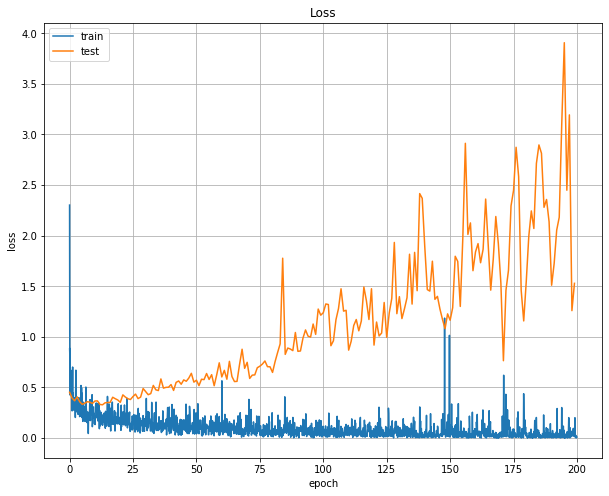

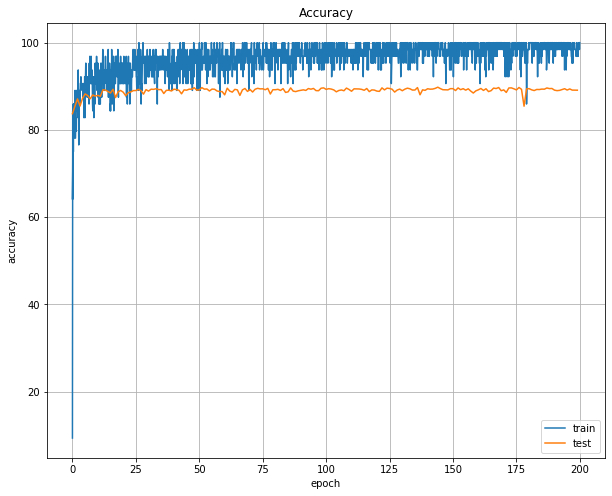

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10]) / len(trainset), train_losses[::10], label='train')
plt.plot(np.array(test_cntr)/ len(trainset), test_losses,  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10])/len(trainset), train_acc[::10], label='train')
plt.plot(np.array(test_cntr)/len(trainset), test_acc,  label='test')
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Видим, что лосс сильно растет. Это является признаком переобучения. Но при этом точность на тесте не падает.

Скорее всего, это происходит потому, что классы сильно различаются. Модель вследствие простоты выборки практически не может ошибаться в сторону другого класса. Растет лосс, т.к. модель переобучается, т.е. подстраивается под некоторые признаки трэйн сета, но этого не достаточно, чтобы ошибаться в сторону других классов. То есть параметры сети подстроились под трейн и картинки одного и того же класса стали больше различаться.

Возможно, чтобы наблюдать переобучение стоит уменьшить трэйн выборку.

# Часть 3
Добавим дропаут и батчнорм.

In [ ]:
class CNN_OF_(nn.Module):
  def __init__(self):
    super(CNN_OF_, self).__init__()
    self.fc1 = nn.Linear(784, 1000)
    self.drop1 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(1000, 1000)
    self.fc2_bn = nn.BatchNorm1d(1000)
    self.drop2 = nn.Dropout(0.4)
    self.fc3 = nn.Linear(1000, 1000)
    self.fc3_bn = nn.BatchNorm1d(1000)
    self.drop3 = nn.Dropout(0.4)
    self.fc4 = nn.Linear(1000, 1000)
    self.fc4_bn = nn.BatchNorm1d(1000)
    self.drop4 = nn.Dropout(0.4)
    self.out = nn.Linear(1000, 10)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2_bn(self.fc2(x)))
    x = self.drop2(x)
    x = F.relu(self.fc3_bn(self.fc2(x)))
    x = self.drop3(x)
    x = F.relu(self.fc4_bn(self.fc2(x)))
    x = self.drop4(x)
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
n_epoches = 100

train_losses = []
test_losses = []
train_acc=[]
test_acc=[]
train_cntr = []
test_counter = [i*len(trainset) for i in range(n_epoches)]
proba = []


net = CNN_OF_()
net=net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1, Images: [0/60000], Loss: 2.3872 Accuracy: 9.38%
Train Epoch: 1, Images: [640/60000], Loss: 1.2918 Accuracy: 45.31%
Train Epoch: 1, Images: [1280/60000], Loss: 1.1574 Accuracy: 54.69%
Train Epoch: 1, Images: [1920/60000], Loss: 0.8297 Accuracy: 75.00%
Train Epoch: 1, Images: [2560/60000], Loss: 1.1202 Accuracy: 60.94%
Train Epoch: 1, Images: [3200/60000], Loss: 0.8234 Accuracy: 68.75%
Train Epoch: 1, Images: [3840/60000], Loss: 0.6378 Accuracy: 78.12%
Train Epoch: 1, Images: [4480/60000], Loss: 0.8908 Accuracy: 59.38%
Train Epoch: 1, Images: [5120/60000], Loss: 0.7401 Accuracy: 67.19%
Train Epoch: 1, Images: [5760/60000], Loss: 0.5490 Accuracy: 78.12%
Train Epoch: 1, Images: [6400/60000], Loss: 0.6017 Accuracy: 81.25%
Train Epoch: 1, Images: [7040/60000], Loss: 0.7493 Accuracy: 79.69%
Train Epoch: 1, Images: [7680/60000], Loss: 0.5110 Accuracy: 82.81%
Train Epoch: 1, Images: [8320/60000], Loss: 0.6502 Accuracy: 71.88%
Train Epoch: 1, Images: [8960/60000], Loss: 0.5622 Ac

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4571, Accuracy: 8321/10000 (83.21%)

Train Epoch: 2, Images: [0/60000], Loss: 0.4136 Accuracy: 84.38%
Train Epoch: 2, Images: [640/60000], Loss: 0.4754 Accuracy: 78.12%
Train Epoch: 2, Images: [1280/60000], Loss: 0.5236 Accuracy: 78.12%
Train Epoch: 2, Images: [1920/60000], Loss: 0.5276 Accuracy: 81.25%
Train Epoch: 2, Images: [2560/60000], Loss: 0.4987 Accuracy: 76.56%
Train Epoch: 2, Images: [3200/60000], Loss: 0.3752 Accuracy: 87.50%
Train Epoch: 2, Images: [3840/60000], Loss: 0.3778 Accuracy: 89.06%
Train Epoch: 2, Images: [4480/60000], Loss: 0.5121 Accuracy: 79.69%
Train Epoch: 2, Images: [5120/60000], Loss: 0.3835 Accuracy: 81.25%
Train Epoch: 2, Images: [5760/60000], Loss: 0.5008 Accuracy: 79.69%
Train Epoch: 2, Images: [6400/60000], Loss: 0.4963 Accuracy: 82.81%
Train Epoch: 2, Images: [7040/60000], Loss: 0.7352 Accuracy: 73.44%
Train Epoch: 2, Images: [7680/60000], Loss: 0.6505 Accuracy: 79.69%
Train Epoch: 2, Images: [8320/60000], Loss: 0.4906 Accuracy

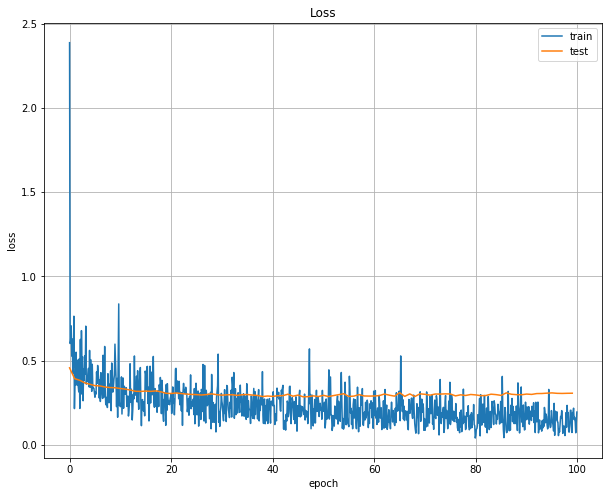

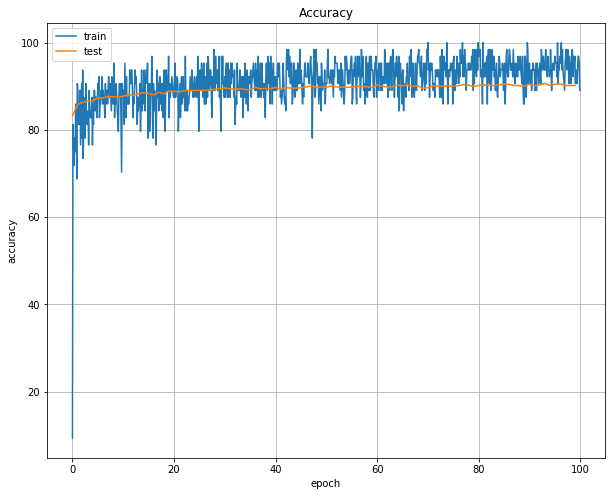

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10]) / len(trainset), train_losses[::10], label='train')
plt.plot(np.array(test_counter)/ len(trainset), test_losses,  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10])/len(trainset), train_acc[::10], label='train')
plt.plot(np.array(test_counter)/len(trainset), test_acc,  label='test')
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Видим, что лосс теперь не возрастает. Значит, переобучение не наблюдается.

 Качество чуть-чуть возрасло (~1%). 

 Это согласутся с гипотезой, что классы достаточно просто различимы.

 # Часть 1
 ### Продолжение

Также попробуем добавить батчнорм и дропаут в нейросеть из первой части лабы. Посмотрим, улучшится ли предсказание.

In [ ]:
class CNN_(nn.Module):
  def __init__(self):
    super(CNN_, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(64 * 7 * 7, 1000)
    self.drop1 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(1000, 200)
    self.drop2 = nn.Dropout(0.4)
    self.out = nn.Linear(200, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(x)), 2))
    x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2(x))
    x = self.drop2(x)
    x = F.log_softmax(self.out(x))
    return x

In [ ]:
n_epoches = 100

train_losses = []
test_losses = []
train_acc=[]
test_acc=[]
train_cntr = []
test_counter = [i*len(trainset) for i in range(n_epoches)]
proba = []


net = CNN_()
net=net.to('cuda')
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
for epoch in range(1, n_epoches + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1, Images: [0/60000], Loss: 2.3308 Accuracy: 9.38%
Train Epoch: 1, Images: [640/60000], Loss: 1.2703 Accuracy: 46.88%
Train Epoch: 1, Images: [1280/60000], Loss: 0.9759 Accuracy: 65.62%
Train Epoch: 1, Images: [1920/60000], Loss: 0.8509 Accuracy: 67.19%
Train Epoch: 1, Images: [2560/60000], Loss: 0.4148 Accuracy: 84.38%
Train Epoch: 1, Images: [3200/60000], Loss: 0.7422 Accuracy: 67.19%
Train Epoch: 1, Images: [3840/60000], Loss: 0.5879 Accuracy: 75.00%
Train Epoch: 1, Images: [4480/60000], Loss: 0.5496 Accuracy: 78.12%
Train Epoch: 1, Images: [5120/60000], Loss: 0.6314 Accuracy: 73.44%
Train Epoch: 1, Images: [5760/60000], Loss: 0.7757 Accuracy: 71.88%
Train Epoch: 1, Images: [6400/60000], Loss: 0.5369 Accuracy: 78.12%
Train Epoch: 1, Images: [7040/60000], Loss: 0.7685 Accuracy: 76.56%
Train Epoch: 1, Images: [7680/60000], Loss: 0.6025 Accuracy: 79.69%
Train Epoch: 1, Images: [8320/60000], Loss: 0.6469 Accuracy: 75.00%
Train Epoch: 1, Images: [8960/60000], Loss: 0.5164 Ac

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3253, Accuracy: 8820/10000 (88.20%)

Train Epoch: 2, Images: [0/60000], Loss: 0.2954 Accuracy: 85.94%
Train Epoch: 2, Images: [640/60000], Loss: 0.1844 Accuracy: 96.88%
Train Epoch: 2, Images: [1280/60000], Loss: 0.4277 Accuracy: 81.25%
Train Epoch: 2, Images: [1920/60000], Loss: 0.3973 Accuracy: 90.62%
Train Epoch: 2, Images: [2560/60000], Loss: 0.3846 Accuracy: 81.25%
Train Epoch: 2, Images: [3200/60000], Loss: 0.2952 Accuracy: 89.06%
Train Epoch: 2, Images: [3840/60000], Loss: 0.4065 Accuracy: 82.81%
Train Epoch: 2, Images: [4480/60000], Loss: 0.2350 Accuracy: 92.19%
Train Epoch: 2, Images: [5120/60000], Loss: 0.4172 Accuracy: 85.94%
Train Epoch: 2, Images: [5760/60000], Loss: 0.3426 Accuracy: 87.50%
Train Epoch: 2, Images: [6400/60000], Loss: 0.3483 Accuracy: 87.50%
Train Epoch: 2, Images: [7040/60000], Loss: 0.4252 Accuracy: 90.62%
Train Epoch: 2, Images: [7680/60000], Loss: 0.1942 Accuracy: 92.19%
Train Epoch: 2, Images: [8320/60000], Loss: 0.4787 Accuracy

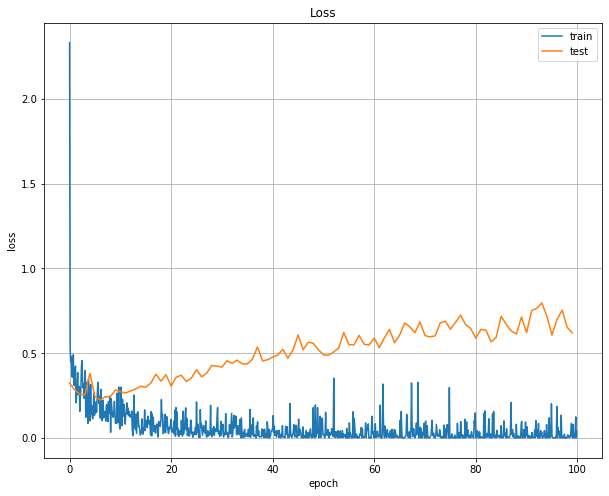

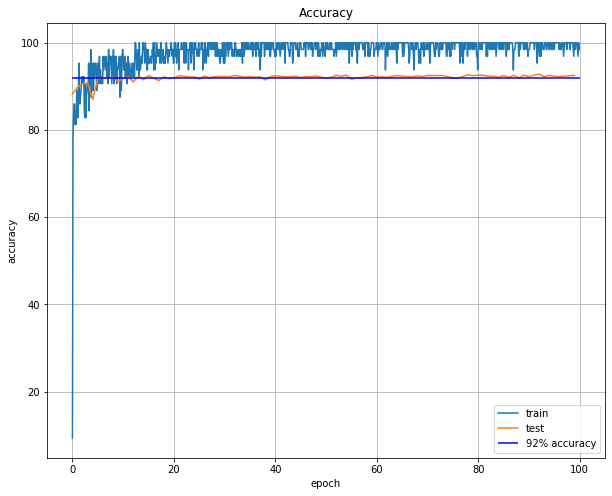

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10]) / len(trainset), train_losses[::10], label='train')
plt.plot(np.array(test_counter)/ len(trainset), test_losses,  label='test')
plt.title("Loss")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(np.array(train_cntr[::10])/len(trainset), train_acc[::10], label='train')
plt.plot(np.array(test_counter)/len(trainset), test_acc,  label='test')
plt.hlines(92, 0, 100, colors='b', label = '92% accuracy', zorder=10)
plt.title("Accuracy")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Точность 92% достигнута.